In [1]:
import pandas as pd
import numpy as np
import sys
import os
import bs4
from IPython.display import display_html,clear_output, HTML
import re
from datetime import datetime
import ast
import itertools
from tqdm import tqdm,trange
from file_tools import *
from request_tools import *
from parse_tools import *
from load_tools import *
from model_tools import *
import pyarrow as pa

pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 30)
pd.set_option('compute.use_numexpr', False)

import warnings
from pandas.errors import PerformanceWarning
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
pd.options.mode.use_inf_as_na = True
warnings.filterwarnings('ignore', category=PerformanceWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

import pandas as pd
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, RFE, mutual_info_regression
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVR


In [2]:
def __process_predictions_validation_set__(preds):
    y_preds = preds.copy().T.drop_duplicates(keep='first').T
    y_true = y_preds[y_preds.columns[y_preds.columns.get_level_values(-2).isin(['y_true'])]]
    is_Val = y_preds[y_preds.columns[y_preds.columns.get_level_values(-2).isin(['is_Val'])]]
    y_preds = y_preds.drop(columns=['y_true','is_Val'],level=-2)

    y_preds_val = pd.DataFrame(index=y_preds.index,columns=y_preds.columns.droplevel(-1).unique())
    for column_indexer in y_preds_val.columns.unique():
        y_preds_val[column_indexer] = y_preds[column_indexer].mul(is_Val.values,axis=0).sum(axis=1)
    y_preds_val.insert(0,'y_true',y_true)
    return y_preds_val


In [3]:
L0_PREDICTIONS_SCORES = pd.read_csv('./08-experiments/dataset-ss0110-mnmx-7fg/WL_reg/20231207-141150/scores.csv',header=[0,1],index_col=[0,1,2,3])
L0_PREDICTIONS_SCORES_FS = L0_PREDICTIONS_SCORES.groupby(level=[0,1,2]).median()
L0_PREDICTIONS_SCORES_FS 

train                                 
                                           mae       mse        r2      rmse   
f_regression           percentile 10  0.363307  0.199715  0.201142  0.446890  \
                                  20  0.342076  0.170281  0.318878  0.412620   
                                  30  0.341177  0.169227  0.323091  0.411353   
mutual_info_regression percentile 10  0.355091  0.187732  0.249072  0.433274   
                                  20  0.343657  0.171366  0.314535  0.413952   
                                  30  0.341868  0.169455  0.322180  0.411639   
r_regression           percentile 10  0.367271  0.199715  0.201142  0.446890   
                                  20  0.342076  0.170281  0.318878  0.412620   
                                  30  0.341177  0.169227  0.323091  0.411353   

                                           val                                
                                           mae       mse        r2      rmse  
f_regression           percentile 10  0.437319  0.229584  0.081664  0.479131  
                                  20  0.434844  0.227646  0.089416  0.477094  
                                  30  0.439835  0.230051  0.079794  0.479593  
mutual_info_regression percentile 10  0.437163  0.229852  0.080592  0.479403  
                                  20  0.439419  0.229053  0.083786  0.478556  
                                  30  0.441925  0.229563  0.081746  0.479101  
r_regression           percentile 10  0.437319  0.228944  0.084224  0.478456  
                                  20  0.434844  0.231594  0.073623  0.481200  
                                  30  0.439835  0.229610  0.081560  0.479114

In [4]:
L0_PREDICTIONS = pd.read_csv('./08-experiments/dataset-ss0110-mnmx-7fg/WL_reg/20231207-141150/predictions.csv',header=[0,1,2,3,4],index_col=[0,1,2])
L0_PREDICTIONS = L0_PREDICTIONS[('f_regression','percentile')]
L0_PREDICTIONS

10   
                                                              y_true   
                                                  Unnamed: 3_level_4   
                       index Team_id                                   
/leagues/NBA_2015.html 8     /teams/BOS/2015.html                  0  \
                             /teams/BRK/2015.html                  0   
                             /teams/CHI/2015.html                  1   
                             /teams/CHO/2015.html                  1   
                             /teams/CLE/2015.html                  0   
                             /teams/DEN/2015.html                  0   
                             /teams/DET/2015.html                  1   
                             /teams/GSW/2015.html                  1   
                             /teams/HOU/2015.html                  1   
                             /teams/LAC/2015.html                  0   
                             /teams/MEM/2015.html                  1   
                             /teams/MIL/2015.html                  0   
                             /teams/MIN/2015.html                  0   
                             /teams/NOP/2015.html                  0   
                             /teams/NYK/2015.html                  0   
...                                                              ...   
/leagues/NBA_2023.html 81    /teams/MIA/2023.html                  1   
                             /teams/MIL/2023.html                  0   
                             /teams/MIN/2023.html                  1   
                             /teams/NOP/2023.html                  0   
                             /teams/NYK/2023.html                  0   
                             /teams/OKC/2023.html                  1   
                             /teams/ORL/2023.html                  0   
                             /teams/PHI/2023.html                  1   
                             /teams/PHO/2023.html                  0   
                             /teams/POR/2023.html                  0   
                             /teams/SAC/2023.html                  0   
                             /teams/SAS/2023.html                  1   
                             /teams/TOR/2023.html                  1   
                             /teams/UTA/2023.html                  0   
                             /teams/WAS/2023.html                  0   

                                                                                
                                                  AdaBoostRegressor             
                                                                  0         1   
                       index Team_id                                            
/leagues/NBA_2015.html 8     /teams/BOS/2015.html          0.549398  0.594494  \
                             /teams/BRK/2015.html          0.383430  0.373946   
                             /teams/CHI/2015.html          0.383430  0.373946   
                             /teams/CHO/2015.html          0.383430  0.373946   
                             /teams/CLE/2015.html          0.798639  0.753949   
                             /teams/DEN/2015.html          0.549398  0.536842   
                             /teams/DET/2015.html          0.285826  0.382646   
                             /teams/GSW/2015.html          0.644678  0.594494   
                             /teams/HOU/2015.html          0.798639  0.753949   
                             /teams/LAC/2015.html          0.543847  0.557576   
                             /teams/MEM/2015.html          0.543847  0.557576   
                             /teams/MIL/2015.html          0.549398  0.594494   
                             /teams/MIN/2015.html          0.285826  0.241667   
                             /teams/NOP/2015.html          0.383430  0.373946   
                             /teams/NYK/2015.html          0.549398  0.382646   
...   

In [5]:
L0_PREDICTIONS_VAL = __process_predictions_validation_set__(L0_PREDICTIONS)
L0_PREDICTIONS_VAL

y_true                10   
                                                         AdaBoostRegressor   
                       index Team_id                                         
/leagues/NBA_2015.html 8     /teams/BOS/2015.html    0.0          0.418673  \
                             /teams/BRK/2015.html    0.0          0.418673   
                             /teams/CHI/2015.html    1.0          0.569600   
                             /teams/CHO/2015.html    1.0          0.418673   
                             /teams/CLE/2015.html    0.0          0.654489   
                             /teams/DEN/2015.html    0.0          0.497445   
                             /teams/DET/2015.html    1.0          0.418673   
                             /teams/GSW/2015.html    1.0          0.654489   
                             /teams/HOU/2015.html    1.0          0.791246   
                             /teams/LAC/2015.html    0.0          0.569600   
                             /teams/MEM/2015.html    1.0          0.569600   
                             /teams/MIL/2015.html    0.0          0.418673   
                             /teams/MIN/2015.html    0.0          0.418673   
                             /teams/NOP/2015.html    0.0          0.418673   
                             /teams/NYK/2015.html    0.0          0.418673   
...                                                  ...               ...   
/leagues/NBA_2023.html 81    /teams/MIA/2023.html    1.0          0.644678   
                             /teams/MIL/2023.html    0.0          0.383430   
                             /teams/MIN/2023.html    1.0          0.549398   
                             /teams/NOP/2023.html    0.0          0.549398   
                             /teams/NYK/2023.html    0.0          0.644678   
                             /teams/OKC/2023.html    1.0          0.644678   
                             /teams/ORL/2023.html    0.0          0.383430   
                             /teams/PHI/2023.html    1.0          0.383430   
                             /teams/PHO/2023.html    0.0          0.543847   
                             /teams/POR/2023.html    0.0          0.549398   
                             /teams/SAC/2023.html    0.0          0.383430   
                             /teams/SAS/2023.html    1.0          0.285826   
                             /teams/TOR/2023.html    1.0          0.543847   
                             /teams/UTA/2023.html    0.0          0.549398   
                             /teams/WAS/2023.html    0.0          0.549398   

                                                                        
                                                  KNeighborsRegressor   
                       index Team_id                                    
/leagues/NBA_2015.html 8     /teams/BOS/2015.html                 0.6  \
                             /teams/BRK/2015.html                 0.2   
                             /teams/CHI/2015.html                 0.6   
                             /teams/CHO/2015.html                 0.4   
                             /teams/CLE/2015.html                 0.8   
                             /teams/DEN/2015.html                 0.2   
                             /teams/DET/2015.html                 0.2   
                             /teams/GSW/2015.html                 0.8   
                             /teams/HOU/2015.html                 0.6   
                             /teams/LAC/2015.html                 0.6   
                             /teams/MEM/2015.html                 0.8   
                             /teams/MIL/2015.html                 0.8   
                             /teams/MIN/2015.html                 0.0   
                             /teams/NOP/2015.html                 0.2   
                             /teams/NYK/2015.html                 0.4   
...                                                               ...   
/leagues/N

In [6]:
X = L0_PREDICTIONS_VAL.drop(columns=['y_true']).iloc[:]
y = L0_PREDICTIONS_VAL['y_true'].iloc[:]

model_stack = ModelStackCV(models='classification',model_params='classification')
predictions = model_stack.fit_predict(X,y,scaler=StandardScaler())
scores = model_stack.score(predictions,score_names='classification')

scores


train                                     val   
                        accuracy        f1 precision    recall  accuracy   
AdaBoostClassifier      0.658807  0.659128  0.658548  0.659716  0.651034  \
KNeighborsClassifier    0.735806  0.736072  0.735327  0.736820  0.604191   
LogisticRegression      0.654050  0.654161  0.653963  0.654362  0.652802   
MLPClassifier           0.704039  0.706825  0.700316  0.713478  0.633305   
RandomForestClassifier  1.000000  1.000000  1.000000  1.000000  0.640220   
RidgeClassifier         0.653842  0.654154  0.653585  0.654725  0.652854   
SVC                     0.661095  0.660658  0.661499  0.659821  0.653114   

                                                      
                              f1 precision    recall  
AdaBoostClassifier      0.655503  0.646843  0.664557  
KNeighborsClassifier    0.604695  0.603907  0.605487  
LogisticRegression      0.648444  0.657090  0.640317  
MLPClassifier           0.638280  0.629816  0.646979  
RandomForestClassifier  0.636208  0.643699  0.628987  
RidgeClassifier         0.648761  0.656898  0.641148  
SVC                     0.652874  0.653278  0.652487

L0B: L0 but with opponent predictions

In [7]:
def load_all_index_df_of_type(idx_directory,idx_type='team_opp_main_index.csv'):
    all_idx_df_dict = {}
    for league in get_all_folders(idx_directory):
        for season in get_all_folders('/'.join([idx_directory,league])):
            for filename in get_all_files('/'.join([idx_directory,league,season]),file_type=idx_type):
                idx_df = load_index_df('/'.join([idx_directory,league,season,filename]))
                all_idx_df_dict[f'/{league}/{season}.html'] = idx_df
    all_idx_df = pd.concat(all_idx_df_dict.values(),keys=all_idx_df_dict.keys(),axis=0).sort_index()
    return all_idx_df

IDX_DIR = './05-data-indexed'
ALL_IDX_DF = load_all_index_df_of_type(IDX_DIR,idx_type='team_opp_main_index.csv')
ALL_IDX_DF
IDX_DF_L0 = ALL_IDX_DF.loc[L0_PREDICTIONS_VAL.index].droplevel(0,axis=0)
IDX_DF_L0

Opp_Curr_Gm   
index Team_id                                            
8     /teams/BOS/2015.html  (10, /teams/PHO/2015.html)  \
      /teams/BRK/2015.html   (9, /teams/POR/2015.html)   
      /teams/CHI/2015.html   (8, /teams/TOR/2015.html)   
      /teams/CHO/2015.html   (8, /teams/PHO/2015.html)   
      /teams/CLE/2015.html   (9, /teams/DEN/2015.html)   
      /teams/DEN/2015.html  (10, /teams/NYK/2015.html)   
      /teams/DET/2015.html   (9, /teams/OKC/2015.html)   
      /teams/GSW/2015.html   (9, /teams/CHO/2015.html)   
      /teams/HOU/2015.html   (8, /teams/PHI/2015.html)   
      /teams/LAC/2015.html  (10, /teams/CHI/2015.html)   
      /teams/MEM/2015.html   (8, /teams/SAC/2015.html)   
      /teams/MIL/2015.html   (9, /teams/ORL/2015.html)   
      /teams/MIN/2015.html   (9, /teams/DAL/2015.html)   
      /teams/NOP/2015.html  (10, /teams/POR/2015.html)   
      /teams/NYK/2015.html   (8, /teams/ORL/2015.html)   
...                                                ...   
81    /teams/MIA/2023.html  (81, /teams/ORL/2023.html)   
      /teams/MIL/2023.html  (81, /teams/TOR/2023.html)   
      /teams/MIN/2023.html  (81, /teams/NOP/2023.html)   
      /teams/NOP/2023.html  (81, /teams/MIN/2023.html)   
      /teams/NYK/2023.html  (81, /teams/IND/2023.html)   
      /teams/OKC/2023.html  (81, /teams/MEM/2023.html)   
      /teams/ORL/2023.html  (81, /teams/MIA/2023.html)   
      /teams/PHI/2023.html  (81, /teams/BRK/2023.html)   
      /teams/PHO/2023.html  (81, /teams/LAC/2023.html)   
      /teams/POR/2023.html  (81, /teams/GSW/2023.html)   
      /teams/SAC/2023.html  (81, /teams/DEN/2023.html)   
      /teams/SAS/2023.html  (81, /teams/DAL/2023.html)   
      /teams/TOR/2023.html  (81, /teams/MIL/2023.html)   
      /teams/UTA/2023.html  (81, /teams/LAL/2023.html)   
      /teams/WAS/2023.html  (81, /teams/HOU/2023.html)   

                                        Opp_Prev_Gm_01   
index Team_id                                            
8     /teams/BOS/2015.html   (9, /teams/PHO/2015.html)  \
      /teams/BRK/2015.html   (8, /teams/POR/2015.html)   
      /teams/CHI/2015.html   (7, /teams/TOR/2015.html)   
      /teams/CHO/2015.html   (7, /teams/PHO/2015.html)   
      /teams/CLE/2015.html   (8, /teams/DEN/2015.html)   
      /teams/DEN/2015.html   (9, /teams/NYK/2015.html)   
      /teams/DET/2015.html   (8, /teams/OKC/2015.html)   
      /teams/GSW/2015.html   (8, /teams/CHO/2015.html)   
      /teams/HOU/2015.html   (7, /teams/PHI/2015.html)   
      /teams/LAC/2015.html   (9, /teams/CHI/2015.html)   
      /teams/MEM/2015.html   (7, /teams/SAC/2015.html)   
      /teams/MIL/2015.html   (8, /teams/ORL/2015.html)   
      /teams/MIN/2015.html   (8, /teams/DAL/2015.html)   
      /teams/NOP/2015.html   (9, /teams/POR/2015.html)   
      /teams/NYK/2015.html   (7, /teams/ORL/2015.html)   
...                                                ...   
81    /teams/MIA/2023.html  (80, /teams/ORL/2023.html)   
      /teams/MIL/2023.html  (80, /teams/TOR/2023.html)   
      /teams/MIN/2023.html  (80, /teams/NOP/2023.html)   
      /teams/NOP/2023.html  (80, /teams/MIN/2023.html)   
      /teams/NYK/2023.html  (80, /teams/IND/2023.html)   
      /teams/OKC/2023.html  (80, /teams/MEM/2023.html)   
      /teams/ORL/2023.html  (80, /teams/MIA/2023.html)   
      /teams/PHI/2023.html  (80, /teams/BRK/2023.html)   
      /teams/PHO/2023.html  (80, /teams/LAC/2023.html)   
      /teams/POR/2023.html  (80, /teams/GSW/2023.html)   
      /teams/SAC/2023.html  (80, /teams/DEN/2023.html)   
      /teams/SAS/2023.html  (80, /teams/DAL/2023.html)   
      /teams/TOR/2023.html  (80, /teams/MIL/2023.html)   
      /teams/UTA/2023.html  (80, /teams/LAL/2023.html)   
      /teams/WAS/2023.html  (80, /teams/HOU/2023.html)   

                                    Opp_Prev_Gm_Opp_01   
index Team_id                                            
8     /teams/BOS/2015.html   (7, /teams/LAC/2015.html)  \
      /teams/BRK/2015.html   (6, /teams

In [8]:
L0_PREDICTIONS_VAL_TM = L0_PREDICTIONS_VAL.droplevel(0)
L0_PREDICTIONS_VAL_OPP = get_opp_stats_df(L0_PREDICTIONS_VAL_TM,IDX_DF_L0['Opp_Curr_Gm'])
L0_PREDICTIONS_VAL_TM_OPP = pd.concat([L0_PREDICTIONS_VAL_TM,L0_PREDICTIONS_VAL_OPP],keys=['Team','Opp'],axis=1)
L0_LABELS_TM = L0_PREDICTIONS_VAL_TM_OPP.pop(('Team','y_true'))
L0_LABELS_OPP = L0_PREDICTIONS_VAL_TM_OPP.pop(('Opp','y_true'))
L0_PREDICTIONS_VAL_TM_OPP

Team                       
                                          10                       
                           AdaBoostRegressor KNeighborsRegressor   
index Team_id                                                      
8     /teams/BOS/2015.html          0.418673                 0.6  \
      /teams/BRK/2015.html          0.418673                 0.2   
      /teams/CHI/2015.html          0.569600                 0.6   
      /teams/CHO/2015.html          0.418673                 0.4   
      /teams/CLE/2015.html          0.654489                 0.8   
      /teams/DEN/2015.html          0.497445                 0.2   
      /teams/DET/2015.html          0.418673                 0.2   
      /teams/GSW/2015.html          0.654489                 0.8   
      /teams/HOU/2015.html          0.791246                 0.6   
      /teams/LAC/2015.html          0.569600                 0.6   
      /teams/MEM/2015.html          0.569600                 0.8   
      /teams/MIL/2015.html          0.418673                 0.8   
      /teams/MIN/2015.html          0.418673                 0.0   
      /teams/NOP/2015.html          0.418673                 0.2   
      /teams/NYK/2015.html          0.418673                 0.4   
...                                      ...                 ...   
81    /teams/MIA/2023.html          0.644678                 0.8   
      /teams/MIL/2023.html          0.383430                 0.4   
      /teams/MIN/2023.html          0.549398                 0.6   
      /teams/NOP/2023.html          0.549398                 0.4   
      /teams/NYK/2023.html          0.644678                 0.8   
      /teams/OKC/2023.html          0.644678                 0.4   
      /teams/ORL/2023.html          0.383430                 0.2   
      /teams/PHI/2023.html          0.383430                 0.4   
      /teams/PHO/2023.html          0.543847                 0.6   
      /teams/POR/2023.html          0.549398                 0.4   
      /teams/SAC/2023.html          0.383430                 0.4   
      /teams/SAS/2023.html          0.285826                 0.4   
      /teams/TOR/2023.html          0.543847                 0.6   
      /teams/UTA/2023.html          0.549398                 0.2   
      /teams/WAS/2023.html          0.549398                 1.0   

                                                           
                                                           
                           LinearRegression MLPRegressor   
index Team_id                                              
8     /teams/BOS/2015.html         0.559769     0.590065  \
      /teams/BRK/2015.html         0.362885     0.048259   
      /teams/CHI/2015.html         0.358978     0.201287   
      /teams/CHO/2015.html         0.283859     0.174385   
      /teams/CLE/2015.html         0.765945     0.863598   
      /teams/DEN/2015.html         0.438202     0.217713   
      /teams/DET/2015.html         0.367020     0.056575   
      /teams/GSW/2015.html         0.734833     1.056323   
      /teams/HOU/2015.html         0.996323     0.738696   
      /teams/LAC/2015.html         0.538483     0.644247   
      /teams/MEM/2015.html         0.644440     0.640827   
      /teams/MIL/2015.html         0.493240     0.028509   
      /teams/MIN/2015.html         0.162598     0.011260   
      /teams/NOP/2015.html         0.406845     0.396905   
      /teams/NYK/2015.html         0.572144     0.585962   
...                                     ...          ...   
81    /teams/MIA/2023.html         0.716797     0.678826   
      /teams/MIL/2023.html         0.604980     0.687791   
      /teams/MIN/2023.html         0.524658     0.796880   
      /teams/NOP/2023.html         0.472534     0.433073   
      /teams/NYK/2023.html         0.786743     0.617465   
      /teams/OKC/2023.html         0.440796     0.634322   
      /teams/ORL/2023.html         0.283691     0.333017   
      /teams/PHI/2023.html         0.45

In [9]:
X,y = L0_PREDICTIONS_VAL_TM_OPP,L0_LABELS_TM
model_stack = ModelStackCV(models='classification',model_params='classification')
predictions = model_stack.fit_predict(X,y,cv=3,scaler=StandardScaler())
scores = model_stack.score(predictions,score_names='classification')
scores

train                                     val   
                        accuracy        f1 precision    recall  accuracy   
AdaBoostClassifier      0.657559  0.657161  0.657859  0.656494  0.648694  \
KNeighborsClassifier    0.735520  0.735506  0.735544  0.735469  0.606687   
LogisticRegression      0.655350  0.655369  0.655336  0.655402  0.651398   
MLPClassifier           0.734793  0.731958  0.739938  0.724397  0.604034   
RandomForestClassifier  0.999974  0.999974  1.000000  0.999948  0.643027   
RidgeClassifier         0.655818  0.655816  0.655815  0.655817  0.652906   
SVC                     0.663798  0.663716  0.663869  0.663564  0.653894   

                                                      
                              f1 precision    recall  
AdaBoostClassifier      0.647186  0.650140  0.644275  
KNeighborsClassifier    0.606743  0.606649  0.606837  
LogisticRegression      0.651234  0.651541  0.650928  
MLPClassifier           0.595880  0.608708  0.583759  
RandomForestClassifier  0.640584  0.644963  0.636267  
RidgeClassifier         0.652538  0.653212  0.651865  
SVC                     0.653769  0.654010  0.653529

Explore Consistent vs. Symmetrical Cases

In [11]:
L0_PREDICTIONS_VAL_TM_OPP = L0_PREDICTIONS_VAL_TM_OPP.reorder_levels([1,2,0],axis=1).sort_index(axis=1)
column_indexer = L0_PREDICTIONS_VAL_TM_OPP.columns.droplevel(-1).unique()[0]
L0_PREDICTIONS_VAL_TM_OPP_MODEL = L0_PREDICTIONS_VAL_TM_OPP.loc[:,column_indexer]
L0_PREDICTIONS_VAL_TM_OPP_MODEL['Diff'] = L0_PREDICTIONS_VAL_TM_OPP_MODEL['Team'] - L0_PREDICTIONS_VAL_TM_OPP_MODEL['Opp']
L0_PREDICTIONS_VAL_TM_OPP_MODEL['y_pred'] = (L0_PREDICTIONS_VAL_TM_OPP_MODEL['Team'] > L0_PREDICTIONS_VAL_TM_OPP_MODEL['Opp']).astype(int)
L0_PREDICTIONS_VAL_TM_OPP_MODEL['y_true'] = L0_LABELS_TM
L0_PREDICTIONS_VAL_TM_OPP_MODEL
    # L0_PREDICTIONS_VAL_TM_OPP[column_indexer] = L0_PREDICTIONS_VAL_TM_OPP[column_indexer].mul(L0_PREDICTIONS_VAL_TM_OPP[('Team','is_Val')].values,axis=0)
# L0_PREDICTIONS_VAL_TM_OPP


/var/folders/fr/37hzr_m96pl96wysz0n2sxd40000gn/T/ipykernel_48447/480660561.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  L0_PREDICTIONS_VAL_TM_OPP_MODEL['Diff'] = L0_PREDICTIONS_VAL_TM_OPP_MODEL['Team'] - L0_PREDICTIONS_VAL_TM_OPP_MODEL['Opp']
/var/folders/fr/37hzr_m96pl96wysz0n2sxd40000gn/T/ipykernel_48447/480660561.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  L0_PREDICTIONS_VAL_TM_OPP_MODEL['y_pred'] = (L0_PREDICTIONS_VAL_TM_OPP_MODEL['Team'] > L0_PREDICTIONS_VAL_TM_OPP_MODEL['Opp']).astype(i

Opp      Team      Diff  y_pred  y_true
index Team_id                                                           
8     /teams/BOS/2015.html  0.418673  0.418673  0.000000       0     0.0
      /teams/BRK/2015.html  0.654489  0.418673 -0.235816       0     0.0
      /teams/CHI/2015.html  0.428795  0.569600  0.140805       1     1.0
      /teams/CHO/2015.html  0.654489  0.418673 -0.235816       0     1.0
      /teams/CLE/2015.html  0.418673  0.654489  0.235816       1     0.0
      /teams/DEN/2015.html  0.265027  0.497445  0.232417       1     0.0
      /teams/DET/2015.html  0.654489  0.418673 -0.235816       0     1.0
      /teams/GSW/2015.html  0.418673  0.654489  0.235816       1     1.0
      /teams/HOU/2015.html  0.265027  0.791246  0.526218       1     1.0
      /teams/LAC/2015.html  0.428795  0.569600  0.140805       1     0.0
      /teams/MEM/2015.html  0.569600  0.569600  0.000000       0     1.0
      /teams/MIL/2015.html  0.418673  0.418673  0.000000       0     0.0
      /teams/MIN/2015.html  0.654489  0.418673 -0.235816       0     0.0
      /teams/NOP/2015.html  0.654489  0.418673 -0.235816       0     0.0
      /teams/NYK/2015.html  0.418673  0.418673  0.000000       0     0.0
...                              ...       ...       ...     ...     ...
81    /teams/MIA/2023.html  0.383430  0.644678  0.261249       1     1.0
      /teams/MIL/2023.html  0.543847  0.383430 -0.160418       0     0.0
      /teams/MIN/2023.html  0.549398  0.549398  0.000000       0     1.0
      /teams/NOP/2023.html  0.549398  0.549398  0.000000       0     0.0
      /teams/NYK/2023.html  0.383430  0.644678  0.261249       1     0.0
      /teams/OKC/2023.html  0.383430  0.644678  0.261249       1     1.0
      /teams/ORL/2023.html  0.644678  0.383430 -0.261249       0     0.0
      /teams/PHI/2023.html  0.543847  0.383430 -0.160418       0     1.0
      /teams/PHO/2023.html  0.383430  0.543847  0.160418       1     0.0
      /teams/POR/2023.html  0.549398  0.549398  0.000000       0     0.0
      /teams/SAC/2023.html  0.543847  0.383430 -0.160418       0     0.0
      /teams/SAS/2023.html  0.798639  0.285826 -0.512814       0     1.0
      /teams/TOR/2023.html  0.383430  0.543847  0.160418       1     1.0
      /teams/UTA/2023.html  0.644678  0.549398 -0.095280       0     0.0
      /teams/WAS/2023.html  0.390282  0.549398  0.159116       1     0.0

[19234 rows x 5 columns]

<Axes: xlabel='Diff', ylabel='Count'>

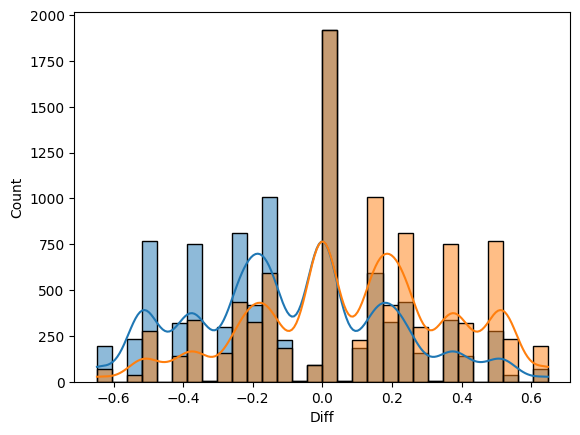

In [12]:
import seaborn as sns
sns.histplot(L0_PREDICTIONS_VAL_TM_OPP_MODEL['Diff'].loc[L0_LABELS_TM==0],bins=30,kde=True)
sns.histplot(L0_PREDICTIONS_VAL_TM_OPP_MODEL['Diff'].loc[L0_LABELS_TM==1],bins=30,kde=True)

In [13]:
from sklearn.metrics import confusion_matrix


for threshold in np.linspace(0.0,1.0,21):
    print(threshold)
    index = L0_PREDICTIONS_VAL_TM_OPP_MODEL[L0_PREDICTIONS_VAL_TM_OPP_MODEL['Diff'].abs() >= threshold].index
    y_true_ = L0_PREDICTIONS_VAL_TM_OPP_MODEL['y_true'].loc[index]
    y_pred_ = L0_PREDICTIONS_VAL_TM_OPP_MODEL['y_pred'].loc[index]
    print(threshold,len(index),accuracy_score(y_true_,y_pred_),f1_score(y_true_,y_pred_),confusion_matrix(y_true_,y_pred_).ravel())
# L0_PREDICTIONS_VAL_TM_OPP_MODEL['Diff'].abs() > 0.2

0.0
0.0 19234 0.6294582510138297 0.5905199655271475 [6968 2649 4478 5139]
0.05
0.05 15204 0.6636411470665614 0.6636411470665614 [5045 2557 2557 5045]
0.1
0.1 15056 0.6647183846971307 0.6647183846971307 [5004 2524 2524 5004]
0.15000000000000002
0.15000000000000002 13810 0.6735698769007965 0.6735698769007965 [4651 2254 2254 4651]
0.2
0.2 9844 0.6980902072328322 0.6980902072328322 [3436 1486 1486 3436]
0.25
0.25 7208 0.717258601553829 0.717258601553829 [2585 1019 1019 2585]
0.30000000000000004
0.30000000000000004 6276 0.7259400892288081 0.7259400892288081 [2278  860  860 2278]
0.35000000000000003
0.35000000000000003 6268 0.7262284620293554 0.7262284620293554 [2276  858  858 2276]
0.4
0.4 3832 0.7468684759916493 0.7468684759916492 [1431  485  485 1431]
0.45
0.45 3166 0.7580543272267846 0.7580543272267845 [1200  383  383 1200]
0.5
0.5 3084 0.7652399481193255 0.7652399481193255 [1180  362  362 1180]
0.55
0.55 542 0.7453874538745388 0.7453874538745388 [202  69  69 202]
0.6000000000000001
0.60

/Users/jasetran/Jase/UM/Git/basketball-analytics/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/jasetran/Jase/UM/Git/basketball-analytics/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jasetran/Jase/UM/Git/basketball-analytics/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jasetran/Jase/UM/Git/basketball-analytics/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/jasetran/Jase/UM/Git/basketball-analytics/.venv/lib/

In [14]:
# for predictor in L0_PREDICTIONS_VAL_TM_OPP.columns.unique(level=[0,1]):
    # X,y = L0_PREDICTIONS_VAL_TM_OPP[predictor],L0_LABELS_TM
    # model_stack = ModelStackCV(models='classification',model_params='classification')
    # predictions = model_stack.fit_predict(X,y)
    # scores = model_stack.score(predictions,score_names='classification')
    # print(f'{predictor}: {scores}')

In [15]:
L0_PREDICTIONS_VAL_TM_OPP.columns.unique(level=0,)

Index(['10', '20', '30'], dtype='object')

In [16]:
L0_SYMM = L0_LABELS_TM[L0_LABELS_TM == L0_LABELS_OPP]
L0_CONS = L0_LABELS_TM[L0_LABELS_TM != L0_LABELS_OPP]
L0_CONS

index  Team_id             
8      /teams/BOS/2015.html    0.0
       /teams/BRK/2015.html    0.0
       /teams/CHI/2015.html    1.0
       /teams/CHO/2015.html    1.0
       /teams/CLE/2015.html    0.0
       /teams/DEN/2015.html    0.0
       /teams/DET/2015.html    1.0
       /teams/GSW/2015.html    1.0
       /teams/HOU/2015.html    1.0
       /teams/LAC/2015.html    0.0
       /teams/MEM/2015.html    1.0
       /teams/MIL/2015.html    0.0
       /teams/MIN/2015.html    0.0
       /teams/NOP/2015.html    0.0
       /teams/NYK/2015.html    0.0
                              ... 
81     /teams/MIA/2023.html    1.0
       /teams/MIL/2023.html    0.0
       /teams/MIN/2023.html    1.0
       /teams/NOP/2023.html    0.0
       /teams/NYK/2023.html    0.0
       /teams/OKC/2023.html    1.0
       /teams/ORL/2023.html    0.0
       /teams/PHI/2023.html    1.0
       /teams/PHO/2023.html    0.0
       /teams/POR/2023.html    0.0
       /teams/SAC/2023.html    0.0
       /teams/SAS/2023.html